<a href="https://colab.research.google.com/github/nantmoe-theingi/airbnb-nz-deception-sentiment/blob/main/05_DistillBERT_deception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np, pandas as pd, torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, set_seed
)

set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [2]:
PROJECT_DRIVE_DIR = "/content/drive/MyDrive/Colab Notebooks/airbnb_nz_deception_sentiment"

from google.colab import drive
drive.mount('/content/drive')

import os
os.makedirs(PROJECT_DRIVE_DIR, exist_ok=True)
print("Drive project folder:", PROJECT_DRIVE_DIR)

Mounted at /content/drive
Drive project folder: /content/drive/MyDrive/Colab Notebooks/airbnb_nz_deception_sentiment


In [3]:
cd {PROJECT_DRIVE_DIR}

/content/drive/MyDrive/Colab Notebooks/airbnb_nz_deception_sentiment


In [5]:
# Load and Split Dataset
df = pd.read_csv("data/deception_opinion_cleaned.csv")
df = df.dropna(subset=["text", "label"])
df["label"] = df["label"].astype(int)

train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["label"], random_state=42)

print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")

Train: 1276 | Val: 160 | Test: 160


In [6]:
# Tokenization
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=256)

train_ds = Dataset.from_pandas(train_df).map(tokenize, batched=True)
val_ds   = Dataset.from_pandas(val_df).map(tokenize, batched=True)
test_ds  = Dataset.from_pandas(test_df).map(tokenize, batched=True)

train_ds.set_format("torch", columns=["input_ids", "attention_mask", "label"])
val_ds.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_ds.set_format("torch", columns=["input_ids", "attention_mask", "label"])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/1276 [00:00<?, ? examples/s]

Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Map:   0%|          | 0/160 [00:00<?, ? examples/s]

In [7]:
# Load Model
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
# Training Arguments
args = TrainingArguments(
    output_dir="artifacts/distilbert_deception",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=2e-5,
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="steps",
    save_steps=500,
    logging_steps=100,
    report_to=[],
)



In [17]:
# Define Metrics

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [18]:
# Train the model
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

/tmp/ipython-input-704814256.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Accuracy,F1
100,0.530200,0.393633,0.812500,0.819277
200,0.360200,0.341817,0.850000,0.862069
300,0.218400,0.379643,0.862500,0.873563
400,0.159000,0.323979,0.925000,0.925926


TrainOutput(global_step=480, training_loss=0.28250775337219236, metrics={'train_runtime': 99.396, 'train_samples_per_second': 38.513, 'train_steps_per_second': 4.829, 'total_flos': 253542601027584.0, 'train_loss': 0.28250775337219236, 'epoch': 3.0})

In [19]:
# Evaluate on Validation and Test Sets
print("\nVALIDATION RESULTS")
val_metrics = trainer.evaluate(val_ds)
print(val_metrics)

print("\nTEST RESULTS")
preds = trainer.predict(test_ds)
y_pred = np.argmax(preds.predictions, axis=-1)
y_true = preds.label_ids

print("Accuracy:", accuracy_score(y_true, y_pred))
print("F1 (deceptive=1):", f1_score(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=["truthful","deceptive"]))

print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))


VALIDATION RESULTS


{'eval_loss': 0.4150168299674988, 'eval_accuracy': 0.875, 'eval_f1': 0.8837209302325582, 'eval_runtime': 1.1508, 'eval_samples_per_second': 139.036, 'eval_steps_per_second': 17.38, 'epoch': 3.0}

TEST RESULTS
Accuracy: 0.8875
F1 (deceptive=1): 0.8941176470588236
              precision    recall  f1-score   support

    truthful       0.94      0.82      0.88        80
   deceptive       0.84      0.95      0.89        80

    accuracy                           0.89       160
   macro avg       0.89      0.89      0.89       160
weighted avg       0.89      0.89      0.89       160

Confusion matrix:
 [[66 14]
 [ 4 76]]


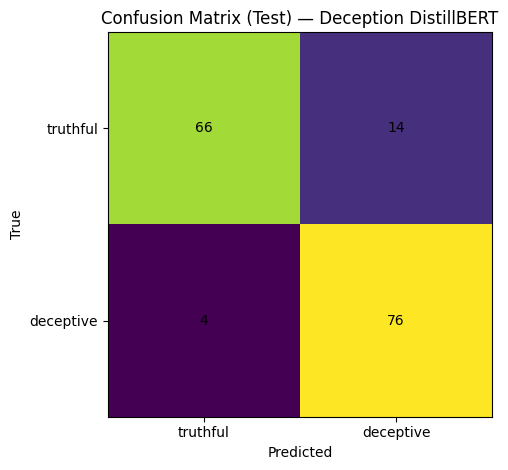

In [25]:
# CM plot
import matplotlib.pyplot as plt
import numpy as np

plt.figure()
plt.imshow(confusion_matrix(y_true, y_pred), interpolation="nearest")
plt.title("Confusion Matrix (Test) — Deception DistillBERT")
plt.xticks([0,1], ["truthful","deceptive"])
plt.yticks([0,1], ["truthful","deceptive"])
for (i,j),v in np.ndenumerate(confusion_matrix(y_true, y_pred)):
    plt.text(j, i, str(v), ha="center", va="center")
plt.xlabel("Predicted");
plt.ylabel("True");
plt.tight_layout();
plt.show()

In [27]:
# 7) Save artifacts
import joblib
from pathlib import Path
ARTIFACTS_DIR = Path("artifacts/deception_distillBERT")
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

# Save the model and tokenizer separately
model.save_pretrained(ARTIFACTS_DIR / "model")
tokenizer.save_pretrained(ARTIFACTS_DIR / "tokenizer")

joblib.dump({"truthful":0, "deceptive":1}, ARTIFACTS_DIR / "label_map.joblib")
print("Saved model, tokenizer, & label map to:", ARTIFACTS_DIR.resolve())

Saved model, tokenizer, & label map to: /content/drive/MyDrive/Colab Notebooks/airbnb_nz_deception_sentiment/artifacts/deception_distillBERT


In [28]:
# Inference helper to reuse
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np

def predict_deception(texts, model_path="artifacts/distilbert_deception/checkpoint-480", max_length=256):
    """
    Predicts whether the given texts are truthful (0) or deceptive (1)
    using the fine-tuned DistilBERT model.
    """
    # Load model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    model.eval()

    # Tokenize inputs
    inputs = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )

    # Run inference
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=-1)
        preds = torch.argmax(probs, dim=-1).numpy()

    # Convert predictions to readable labels
    labels = ["truthful" if p == 0 else "deceptive" for p in preds]
    confidences = probs.max(dim=-1).values.numpy()

    # Print formatted results
    for t, l, c in zip(texts, labels, confidences):
        print(f"📝 Text: {t[:100]}...")
        print(f"→ Prediction: {l.upper()} (Confidence: {c:.3f})\n")

    return labels, confidences


In [29]:
sample_texts = [
    "The room was spotless and the staff were incredibly friendly.",
    "Best hotel ever! The photos are fake but you should totally stay here!",
    "We waited two hours for check-in, and the manager kept making excuses."
]

predict_deception(sample_texts)


📝 Text: The room was spotless and the staff were incredibly friendly....
→ Prediction: DECEPTIVE (Confidence: 0.860)

📝 Text: Best hotel ever! The photos are fake but you should totally stay here!...
→ Prediction: DECEPTIVE (Confidence: 0.963)

📝 Text: We waited two hours for check-in, and the manager kept making excuses....
→ Prediction: TRUTHFUL (Confidence: 0.787)



(['deceptive', 'deceptive', 'truthful'],
 array([0.8599144 , 0.96313494, 0.78651875], dtype=float32))

In [33]:
# model comparison

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

bert_results = {
    "Model": "DistilBERT (fine-tuned)",
    "Accuracy": round(accuracy_score(y_true, y_pred), 4),
    "F1": round(f1_score(y_true, y_pred), 4),
    "Precision": round(precision_score(y_true, y_pred), 4),
    "Recall": round(recall_score(y_true, y_pred), 4)
}

# Append to existing CSV
df = pd.read_csv("figures/model_comparison_svm.csv")
df = pd.concat([df, pd.DataFrame([bert_results])], ignore_index=True)
df.to_csv("figures/model_comparison_deception.csv", index=False)
print(" Added DistilBERT results to model_comparison_deception.csv")


 Added DistilBERT results to model_comparison_deception.csv
